In [ ]:
# Transformers installation
! pip install transformers datasets -q
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.8 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax, rel_entr
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import ast
import math
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

### Download the data ###

In [ ]:
#Mount on drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
%cd /content/gdrive/MyDrive/personal-survey-llm/Data

/content/gdrive/MyDrive/personal-survey-llm/Data


In [ ]:
df = pd.read_csv("Risako_HumanGPT/intramodel_data.csv")

In [ ]:
df.head()

,dataset_name,text_ind,text,prompt,params,human_annots,model_annots
0,SChem5Labels,0,You should support your partner.,"For this task, we want to study people's every...","[1.0, 1.0]",[3 4 3 4 3],[4. 4. 0. 3. 3.]
1,SChem5Labels,1,It's good to be want to know things that could...,"For this task, we want to study people's every...","[1.0, 1.0]",[3 3 3 4 4],[0. 4. 0. 1. 3.]
2,SChem5Labels,2,It is good to have moderation in all activities.,"For this task, we want to study people's every...","[1.0, 1.0]",[2 3 2 3 4],[ 3. 3. nan 3. 3.]
3,SChem5Labels,3,It is wrong to be racist to other people.,"For this task, we want to study people's every...","[1.0, 1.0]",[3 4 3 3 3],[1. 4. 0. 2. 4.]
4,SChem5Labels,4,It's normal to be clean-shaven for special occ...,"For this task, we want to study people's every...","[1.0, 1.0]",[2 3 2 3 2],[2. 2. 1. 0. 3.]


In [ ]:
df.shape

(40410, 7)

In [ ]:
filtered_df = df[df['text']=='You should support your partner.']
filtered_df

,dataset_name,text_ind,text,prompt,params,human_annots,model_annots
0,SChem5Labels,0,You should support your partner.,"For this task, we want to study people's every...","[1.0, 1.0]",[3 4 3 4 3],[4. 4. 0. 3. 3.]
791,SChem5Labels,0,You should support your partner.,"For this task, we want to study people's every...","[0.8, 0.25]",[3 4 3 4 3],[ 3. 3. nan 3. 3.]
1582,SChem5Labels,0,You should support your partner.,"For this task, we want to study people's every...","[0.3, 0.25]",[3 4 3 4 3],[3 3 0 3 3]
2373,SChem5Labels,0,You should support your partner.,"For this task, we want to study people's every...","[0.8, 0.75]",[3 4 3 4 3],[4 4 4 3 3]
3164,SChem5Labels,0,You should support your partner.,"For this task, we want to study people's every...","[0.3, 0.75]",[3 4 3 4 3],[ 3. 3. nan 3. 3.]


In [ ]:
# Grouping by dataset_name and text columns, and getting the size of each group
grouped_df = df.groupby(['dataset_name', 'text']).size().reset_index(name='text_count')
grouped_df['text_count'].value_counts()

5     8076
10       3
Name: text_count, dtype: int64

In [ ]:
# some extras need to be dropped
df.drop_duplicates(subset=['dataset_name', 'text'], keep='first', inplace=True)
print(df.shape)

(8079, 7)


In [ ]:
%cd /content/gdrive/MyDrive/personal-survey-llm/results/Human_GPT/

/content/gdrive/MyDrive/personal-survey-llm/results/Human_GPT


### Aggregate from intermodel data which gives the model name ###

In [ ]:
intermodel_df = pd.read_csv("intermodel_data_cleaned.csv")
intermodel_df.head()

,model_name,dataset_name,text_ind,text,prompt,human_annots,model_annots
0,vicuna,SChem5Labels,0,You should support your partner.,"For this task, we want to study people's every...","[3.0, 4.0, 3.0, 4.0, 3.0]","[4.0, 3.0, 3.0, 4.0, 3.0]"
1,vicuna,SChem5Labels,1,It's good to be want to know things that could...,"For this task, we want to study people's every...","[3.0, 3.0, 3.0, 4.0, 4.0]","[0.0, 3.0, 3.0, 4.0, 3.0]"
2,vicuna,SChem5Labels,2,It is good to have moderation in all activities.,"For this task, we want to study people's every...","[2.0, 3.0, 2.0, 3.0, 4.0]","[3.0, 3.0, 3.0, 4.0, 3.0]"
3,vicuna,SChem5Labels,3,It is wrong to be racist to other people.,"For this task, we want to study people's every...","[3.0, 4.0, 3.0, 3.0, 3.0]","[1.0, 3.0, 3.0, 4.0, 3.0]"
4,vicuna,SChem5Labels,4,It's normal to be clean-shaven for special occ...,"For this task, we want to study people's every...","[2.0, 3.0, 2.0, 3.0, 2.0]","[2.0, 3.0, 3.0, 4.0, 3.0]"


In [ ]:
# We need the model name
result_df = intermodel_df.merge(df,
                               on=['text', 'dataset_name'],
                               how='left',
                               suffixes=('_intermodel', ''))

# Keeping only the common columns from the intermodel_df
columns_to_keep = ['model_name', 'text', 'dataset_name', 'text_ind', 'prompt', 'human_annots_intermodel', 'model_annots_intermodel', 'params']
result_df = result_df[columns_to_keep]
result_df.rename(columns={'human_annots_intermodel': 'human_annots','model_annots_intermodel': 'model_annots' }, inplace=True)

# Printing the DataFrame to see the changes
result_df.head()

,model_name,text,dataset_name,text_ind,prompt,human_annots,model_annots,params
0,vicuna,You should support your partner.,SChem5Labels,0,"For this task, we want to study people's every...","[3.0, 4.0, 3.0, 4.0, 3.0]","[4.0, 3.0, 3.0, 4.0, 3.0]","[1.0, 1.0]"
1,vicuna,It's good to be want to know things that could...,SChem5Labels,1,"For this task, we want to study people's every...","[3.0, 3.0, 3.0, 4.0, 4.0]","[0.0, 3.0, 3.0, 4.0, 3.0]","[1.0, 1.0]"
2,vicuna,It is good to have moderation in all activities.,SChem5Labels,2,"For this task, we want to study people's every...","[2.0, 3.0, 2.0, 3.0, 4.0]","[3.0, 3.0, 3.0, 4.0, 3.0]","[1.0, 1.0]"
3,vicuna,It is wrong to be racist to other people.,SChem5Labels,3,"For this task, we want to study people's every...","[3.0, 4.0, 3.0, 3.0, 3.0]","[1.0, 3.0, 3.0, 4.0, 3.0]","[1.0, 1.0]"
4,vicuna,It's normal to be clean-shaven for special occ...,SChem5Labels,4,"For this task, we want to study people's every...","[2.0, 3.0, 2.0, 3.0, 2.0]","[2.0, 3.0, 3.0, 4.0, 3.0]","[1.0, 1.0]"


In [ ]:
result_df.shape

(40395, 8)

In [ ]:
result_df.dtypes

model_name      object
text            object
dataset_name    object
text_ind         int64
prompt          object
human_annots    object
model_annots    object
params          object
dtype: object

In [ ]:
result_df['params'].value_counts()

[1.0, 1.0]    40395
Name: params, dtype: int64

In [ ]:
grouped_df = result_df.groupby(['text', 'model_name', 'params']).size().reset_index(name='text_count')
grouped_df.head(10) # where are the other params!!!

,text,model_name,params,text_count
0,\r\nMany serial killers and all-around psychop...,baize,"[1.0, 1.0]",1
1,\r\nMany serial killers and all-around psychop...,koala,"[1.0, 1.0]",1
2,\r\nMany serial killers and all-around psychop...,llama2,"[1.0, 1.0]",1
3,\r\nMany serial killers and all-around psychop...,open_ai_gpt35turbo,"[1.0, 1.0]",1
4,\r\nMany serial killers and all-around psychop...,vicuna,"[1.0, 1.0]",1
5,Who Controls the News ... controls your Mind...,baize,"[1.0, 1.0]",1
6,Who Controls the News ... controls your Mind...,koala,"[1.0, 1.0]",1
7,Who Controls the News ... controls your Mind...,llama2,"[1.0, 1.0]",1
8,Who Controls the News ... controls your Mind...,open_ai_gpt35turbo,"[1.0, 1.0]",1
9,Who Controls the News ... controls your Mind...,vicuna,"[1.0, 1.0]",1


In [ ]:
grouped_df['text_count'].value_counts()

1    40395
Name: text_count, dtype: int64

In [ ]:
result_df['human_annots'] = result_df['human_annots'].apply(ast.literal_eval)
result_df['model_annots'] = result_df['model_annots'].apply(ast.literal_eval)

In [ ]:
result_df.isnull().values.any()

False

In [ ]:
result_df.head()

,model_name,text,dataset_name,text_ind,prompt,human_annots,model_annots,params
0,vicuna,You should support your partner.,SChem5Labels,0,"For this task, we want to study people's every...","[3.0, 4.0, 3.0, 4.0, 3.0]","[4.0, 3.0, 3.0, 4.0, 3.0]","[1.0, 1.0]"
1,vicuna,It's good to be want to know things that could...,SChem5Labels,1,"For this task, we want to study people's every...","[3.0, 3.0, 3.0, 4.0, 4.0]","[0.0, 3.0, 3.0, 4.0, 3.0]","[1.0, 1.0]"
2,vicuna,It is good to have moderation in all activities.,SChem5Labels,2,"For this task, we want to study people's every...","[2.0, 3.0, 2.0, 3.0, 4.0]","[3.0, 3.0, 3.0, 4.0, 3.0]","[1.0, 1.0]"
3,vicuna,It is wrong to be racist to other people.,SChem5Labels,3,"For this task, we want to study people's every...","[3.0, 4.0, 3.0, 3.0, 3.0]","[1.0, 3.0, 3.0, 4.0, 3.0]","[1.0, 1.0]"
4,vicuna,It's normal to be clean-shaven for special occ...,SChem5Labels,4,"For this task, we want to study people's every...","[2.0, 3.0, 2.0, 3.0, 2.0]","[2.0, 3.0, 3.0, 4.0, 3.0]","[1.0, 1.0]"


In [ ]:
filtered_df = result_df[result_df['text']=='It is good to be yourself.']
filtered_df

,model_name,text,dataset_name,text_ind,prompt,human_annots,model_annots,params
29,vicuna,It is good to be yourself.,SChem5Labels,29,"For this task, we want to study people's every...","[3.0, 3.0, 3.0, 3.0, 3.0]","[3.0, 3.0, 3.0, 3.0, 3.0]","[1.0, 1.0]"
819,baize,It is good to be yourself.,SChem5Labels,29,"For this task, we want to study people's every...","[3.0, 3.0, 3.0, 3.0, 3.0]","[2.0, 3.0, 3.0, 3.0, 4.0]","[1.0, 1.0]"
1609,llama2,It is good to be yourself.,SChem5Labels,29,"For this task, we want to study people's every...","[3.0, 3.0, 3.0, 3.0, 3.0]","[3.0, 4.0, 0.0, 0.0, -1]","[1.0, 1.0]"
2399,koala,It is good to be yourself.,SChem5Labels,29,"For this task, we want to study people's every...","[3.0, 3.0, 3.0, 3.0, 3.0]","[4.0, 3.0, 3.0, 2.0, 3.0]","[1.0, 1.0]"
3189,open_ai_gpt35turbo,It is good to be yourself.,SChem5Labels,29,"For this task, we want to study people's every...","[3.0, 3.0, 3.0, 3.0, 3.0]","[3.0, 3.0, 3.0, 3.0, 3.0]","[1.0, 1.0]"


In [ ]:
#result_df.to_csv("intramodel_data.csv", index = False, header = True)

In [ ]:
grouped_df = result_df.groupby(['model_name']).size().reset_index(name='text_count')
grouped_df.head(10) # where are the other params!!!

,model_name,text_count
0,baize,8079
1,koala,8079
2,llama2,8079
3,open_ai_gpt35turbo,8079
4,vicuna,8079


In [ ]:
def calculate_iou(human, model):
    intersection = len(set(human) & set(model))
    union = len(set(human) | set(model))
    return intersection / union if union != 0 else 0

result_df['iou'] = result_df.apply(lambda x: calculate_iou(x['human_annots'], x['model_annots']), axis=1)


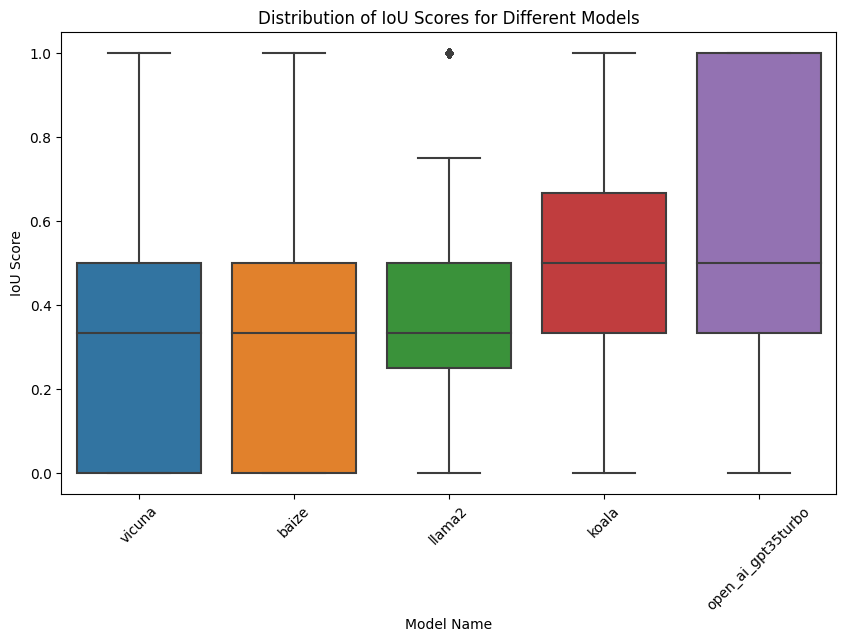

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=result_df, x='model_name', y='iou')
plt.title('Distribution of IoU Scores for Different Models')
plt.xlabel('Model Name')
plt.ylabel('IoU Score')
plt.xticks(rotation=45)
plt.show()


In [ ]:
df = result_df

In [ ]:
%pwd

'/content/gdrive/MyDrive/personal-survey-llm/results/Human_GPT'

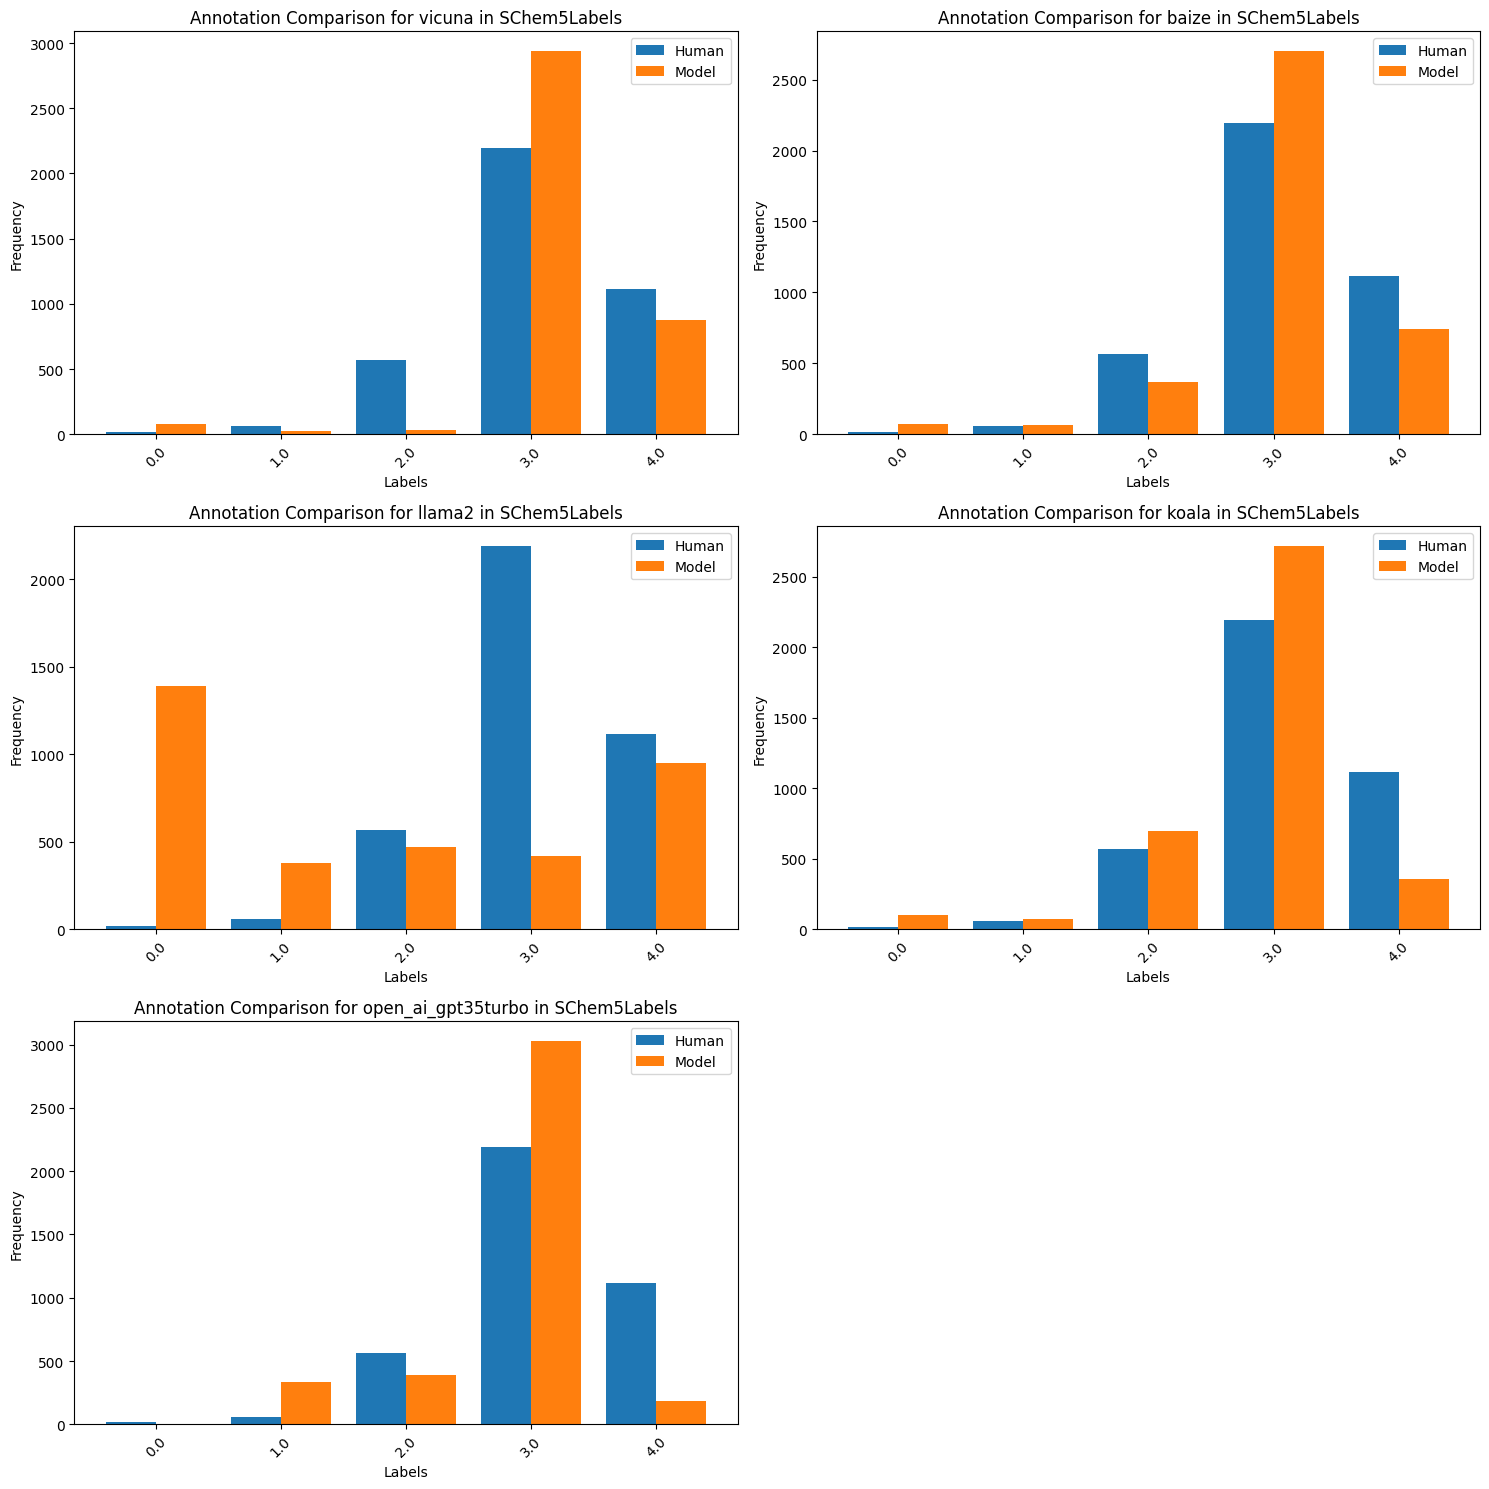

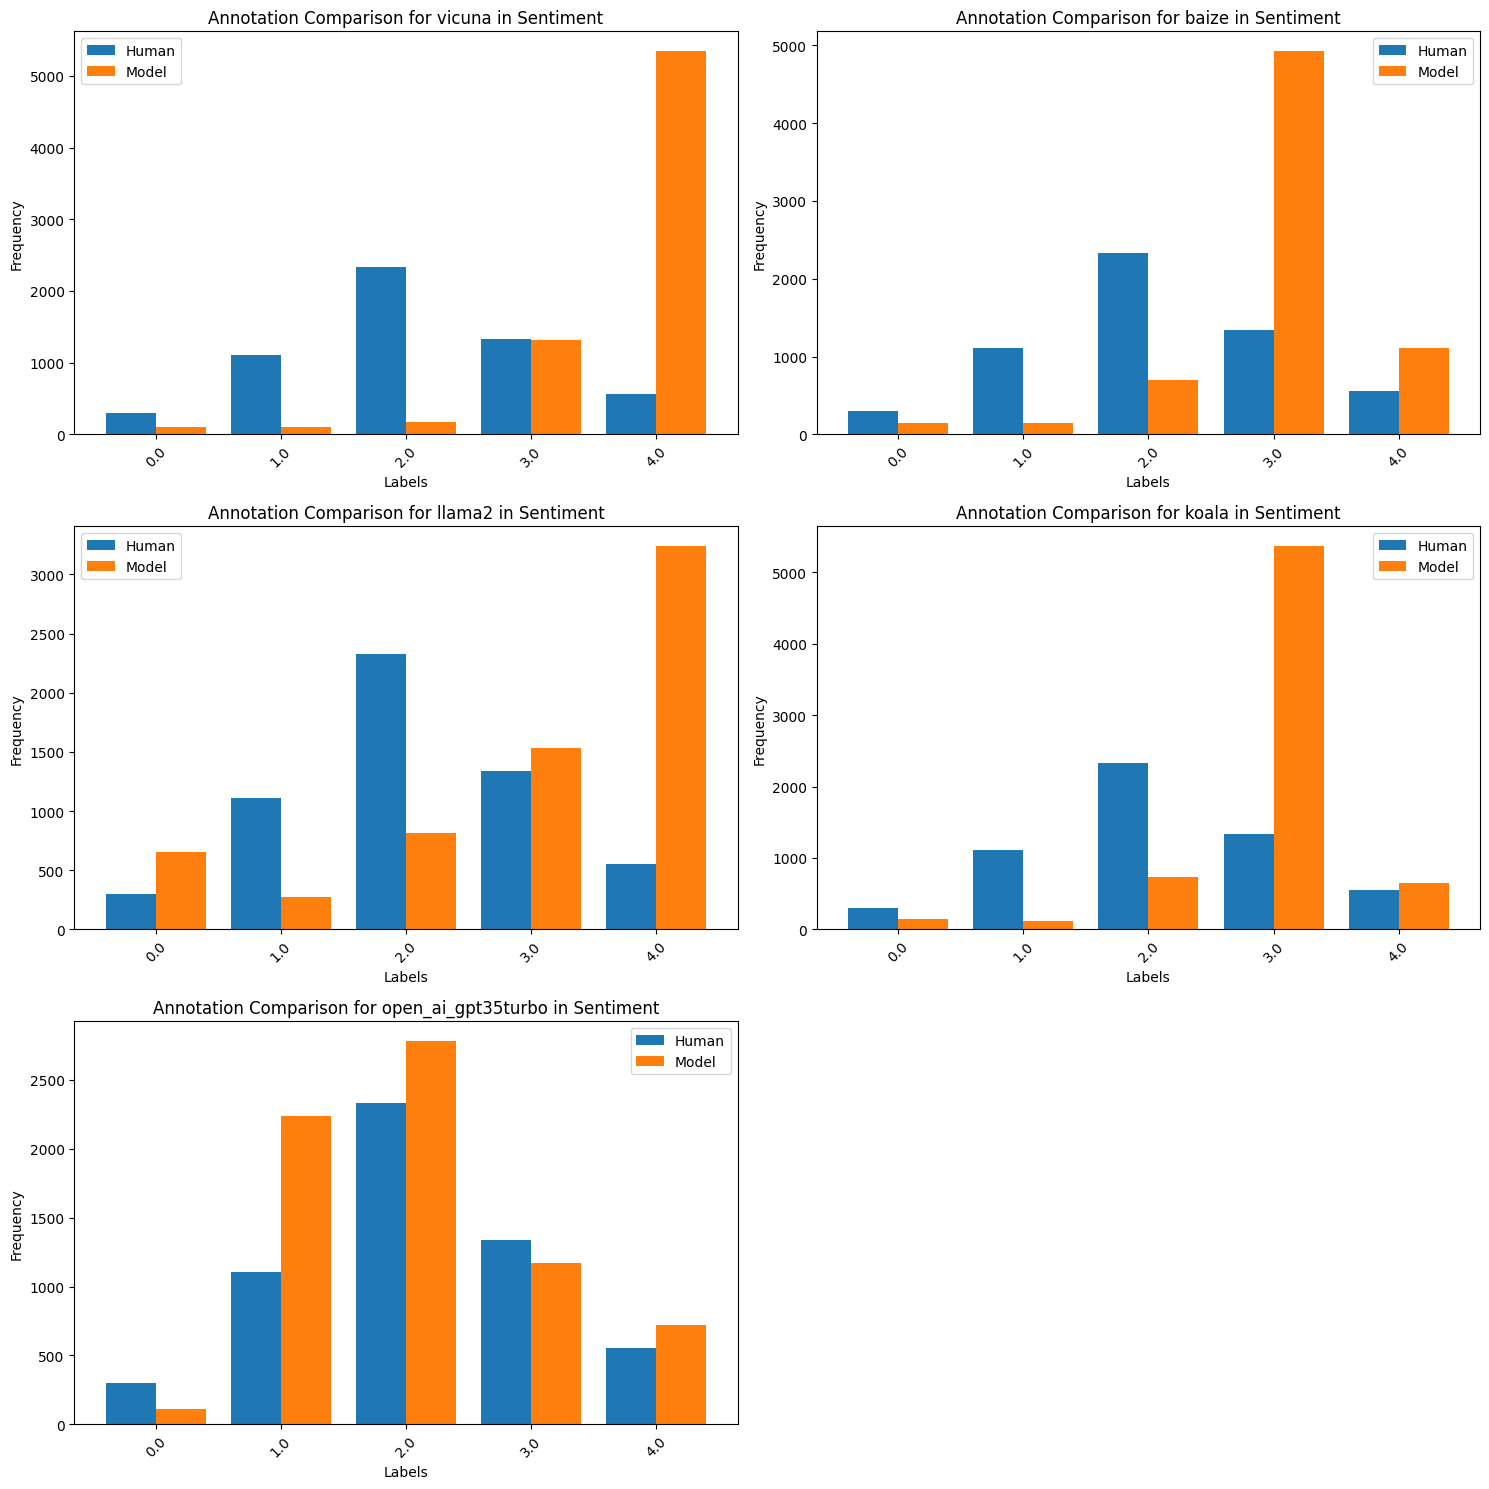

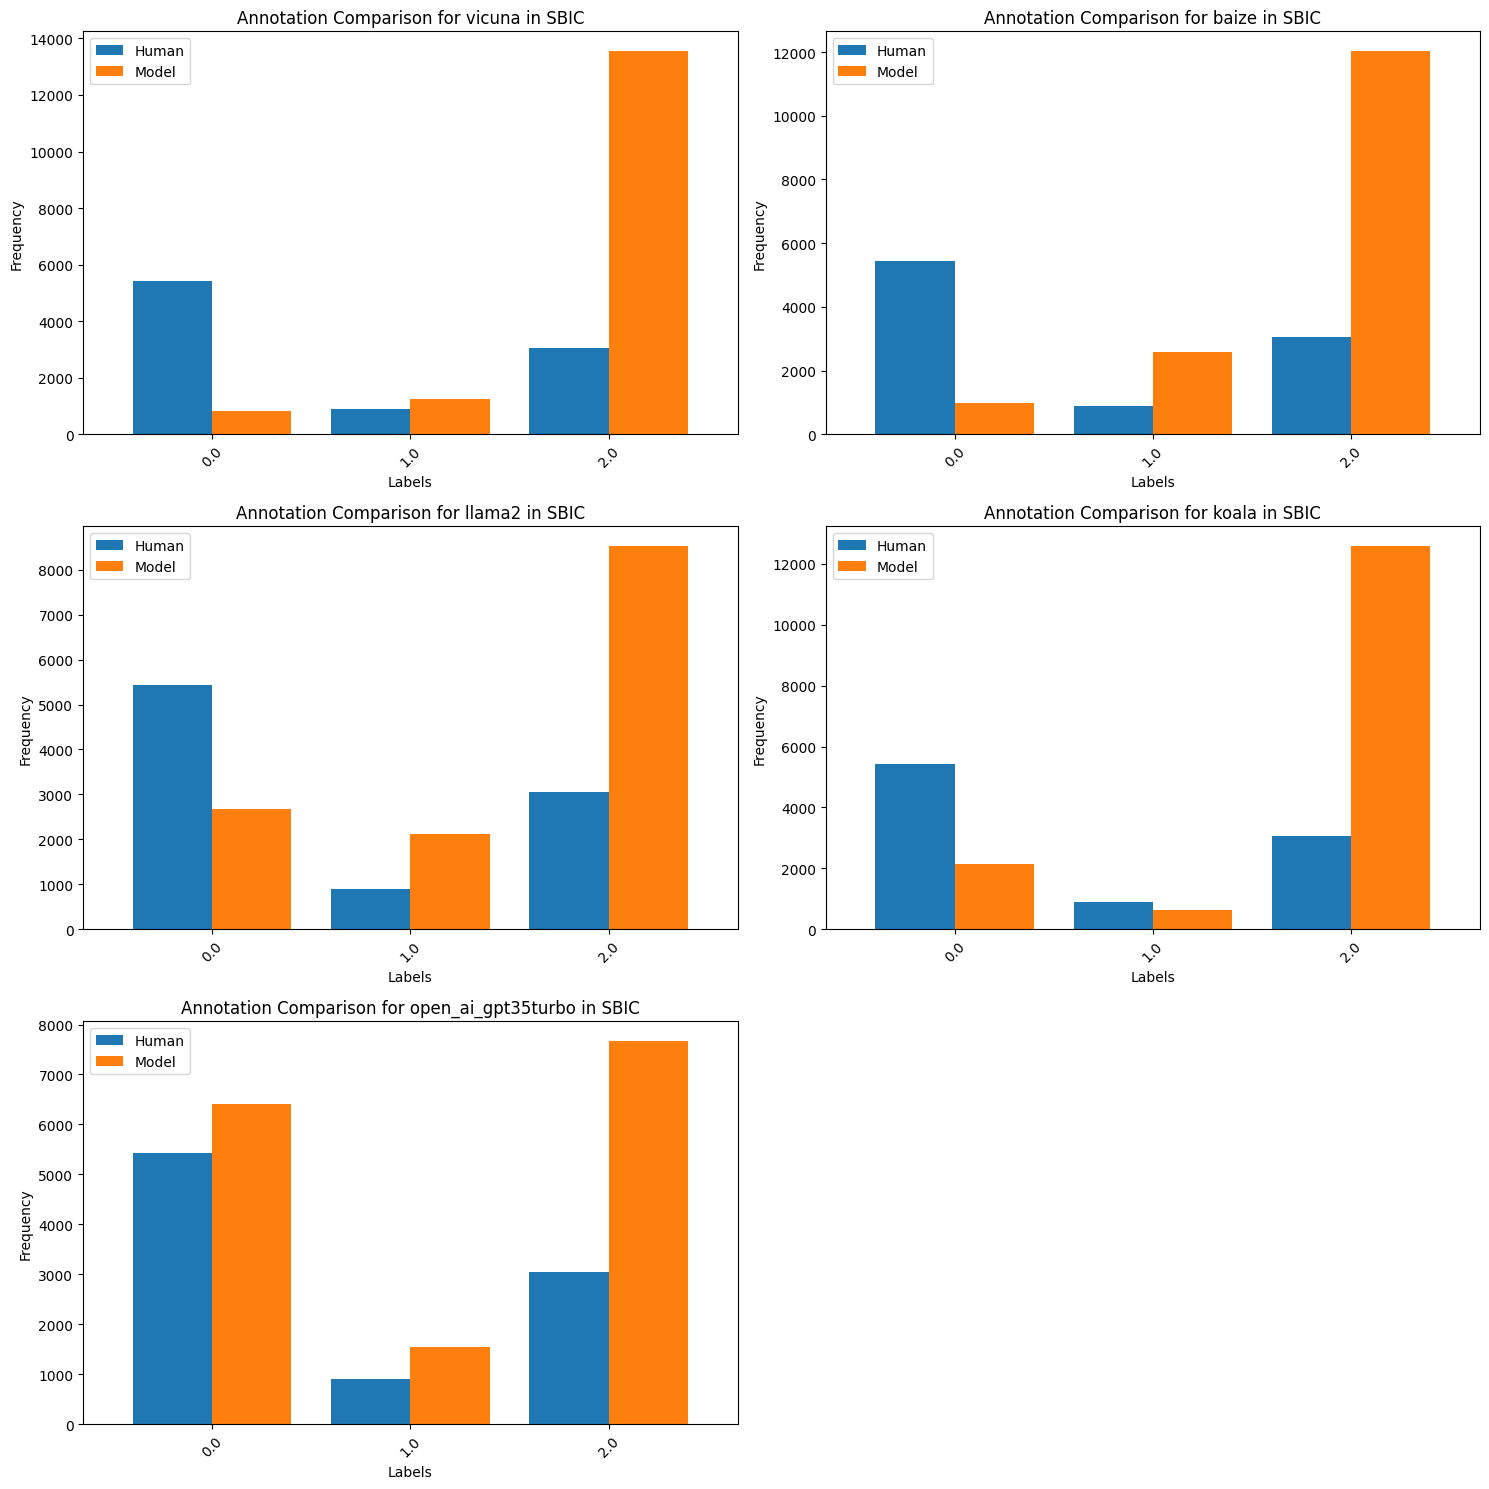

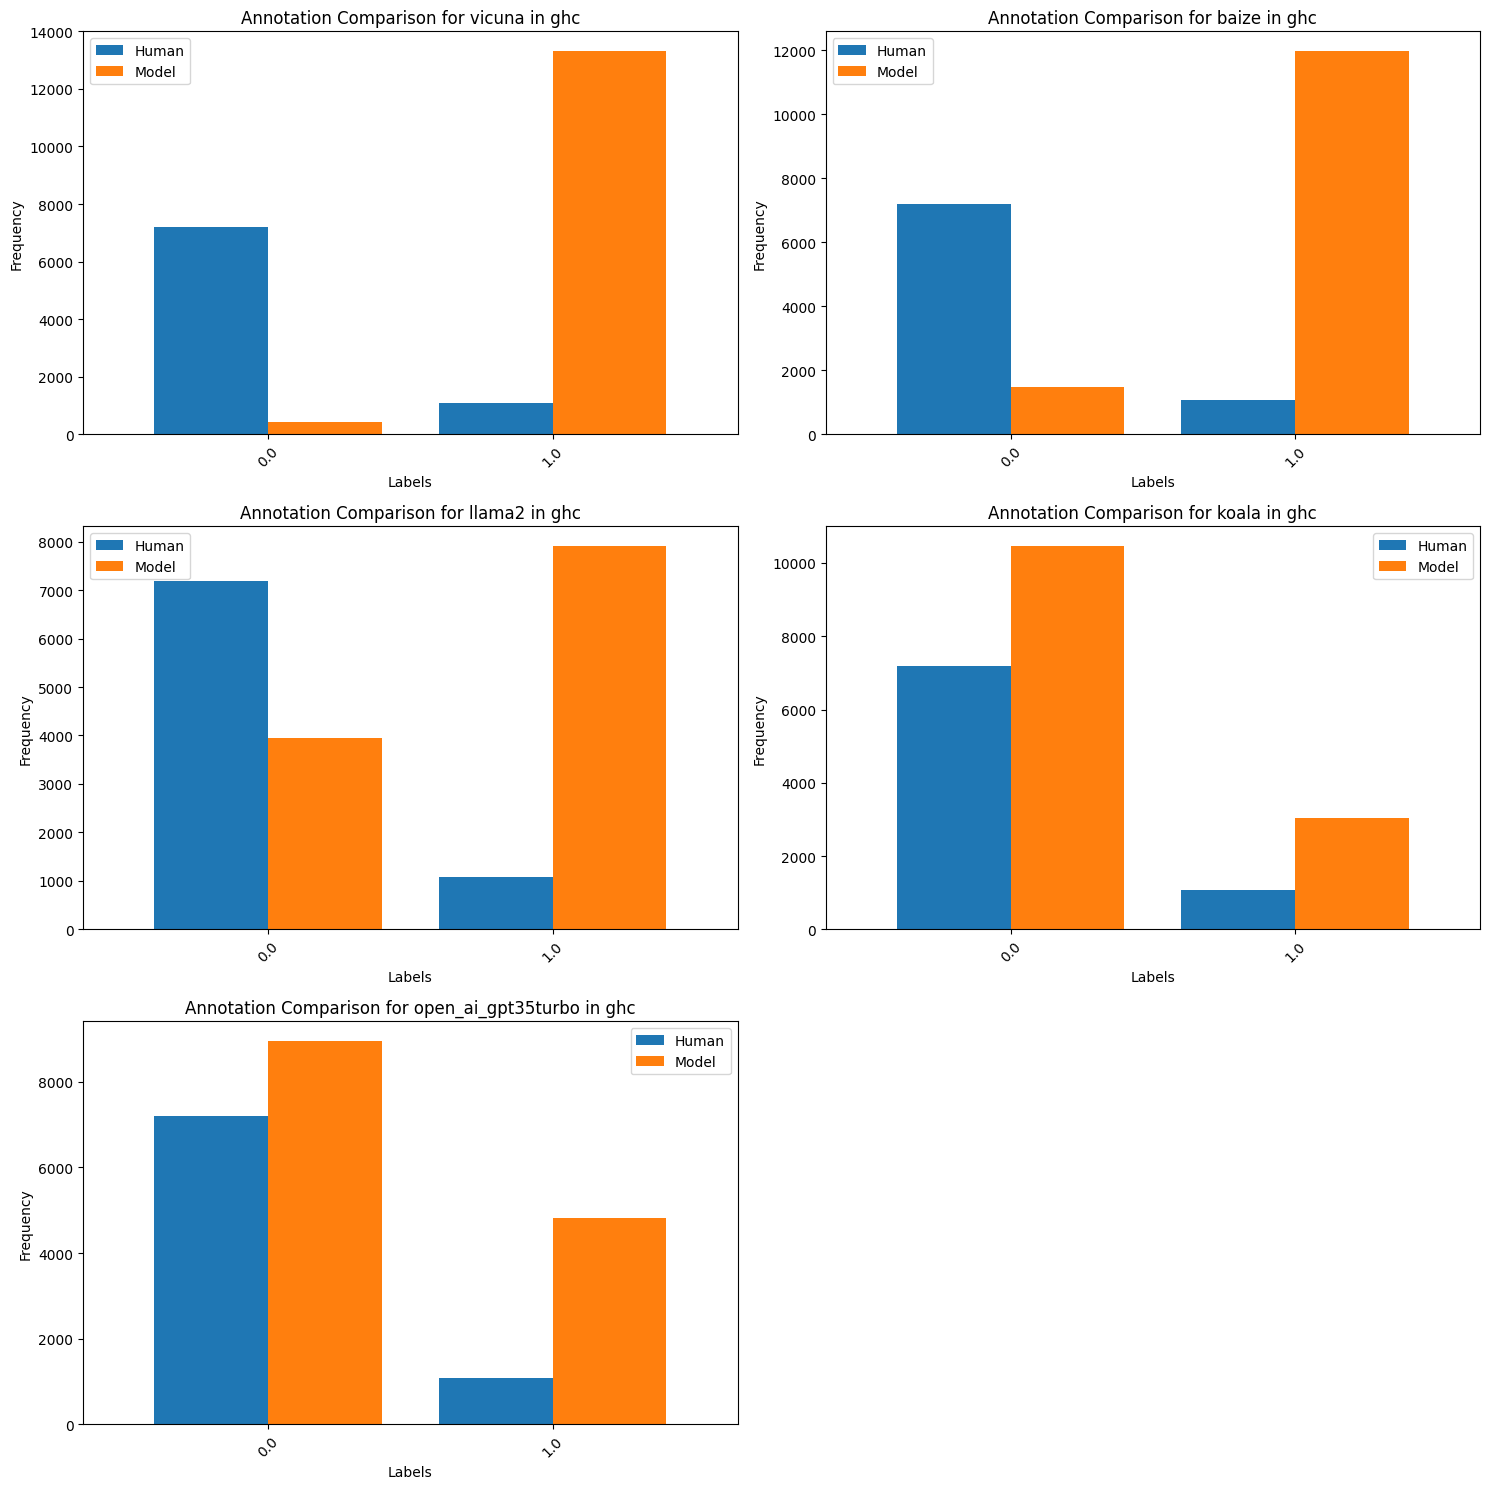

In [ ]:
from collections import Counter

# Number of columns in the grid
num_columns = 2

# Unique models and datasets
unique_models = df['model_name'].unique()
unique_datasets = df['dataset_name'].unique()

# Looping through each dataset
for dataset in unique_datasets:
    dataset_df = df[df['dataset_name'] == dataset]

    # Number of rows in the grid
    num_rows = -(-len(unique_models) // num_columns)  # Ceiling division

    # Create a figure for each dataset
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5*num_rows))
    axs = axs.ravel()  # Flatten the array for easier iteration

    for i, model in enumerate(unique_models):
        model_df = dataset_df[dataset_df['model_name'] == model]

        # Calculate the frequencies for human_annots and model_annots
        human_frequencies = Counter([item for sublist in model_df['human_annots'] for item in sublist])
        model_frequencies = Counter([item for sublist in model_df['model_annots'] for item in sublist])

        # Creating a DataFrame for easy plotting
        combined_df = pd.DataFrame({
            'Labels': list(human_frequencies.keys()),
            'Human': list(human_frequencies.values()),
            'Model': [model_frequencies.get(key, 0) for key in human_frequencies.keys()] # this is where -1 was lost
        })

        # Sort the DataFrame based on Labels for consistency
        combined_df.sort_values('Labels', inplace=True)

        # Plotting
        combined_df.plot(x='Labels', kind='bar', ax=axs[i], width=0.8)
        axs[i].set_title(f'Annotation Comparison for {model} in {dataset}')
        axs[i].set_ylabel('Frequency')
        axs[i].set_xlabel('Labels')
        axs[i].tick_params(axis='x', rotation=45)

    # Remove any unused subplots
    for i in range(len(unique_models), num_rows*num_columns):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()
    # Save the figure as an image file in the "plots" directory
    #plt.savefig(f'plots/annotation_comparison_{dataset}.png')

    # Close the figure to free up memory
    #plt.close(fig)

In [ ]:
df = result_df

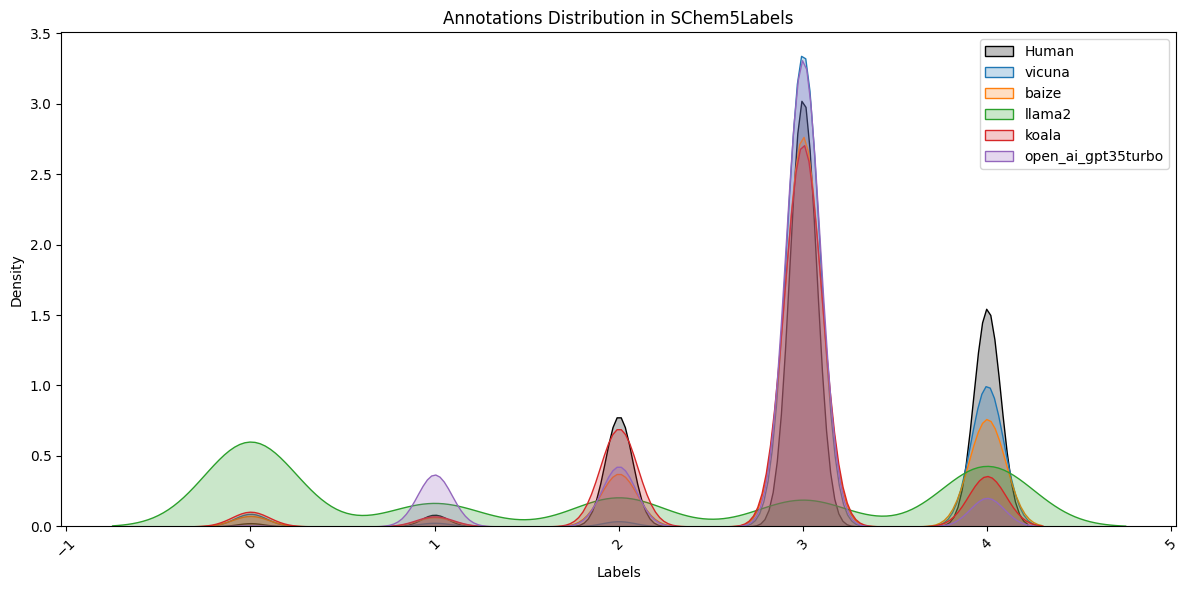

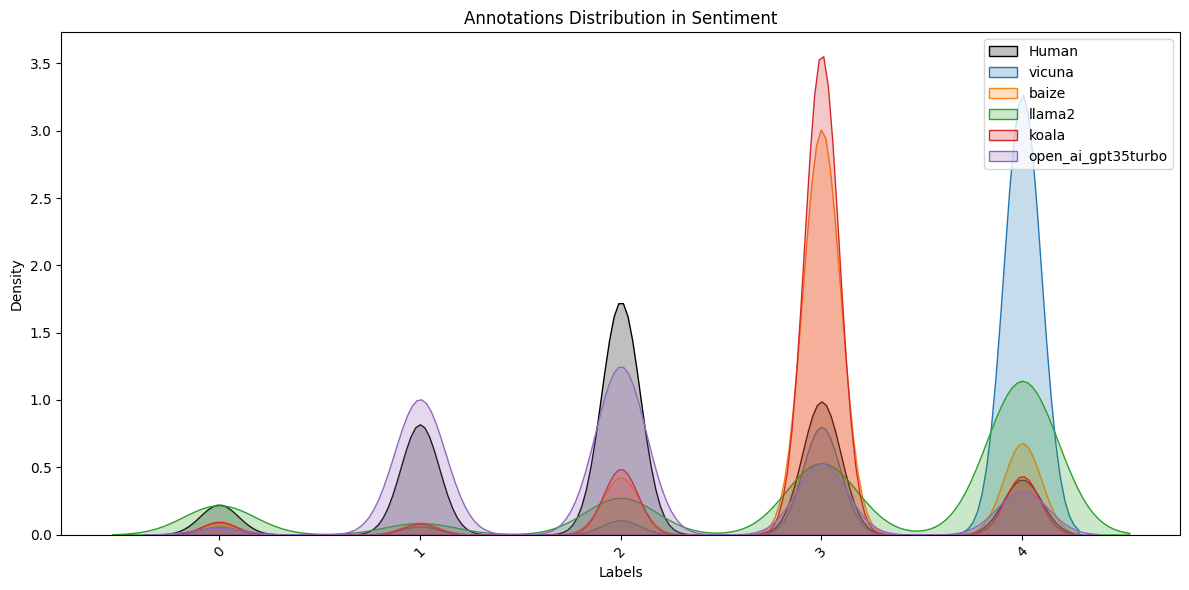

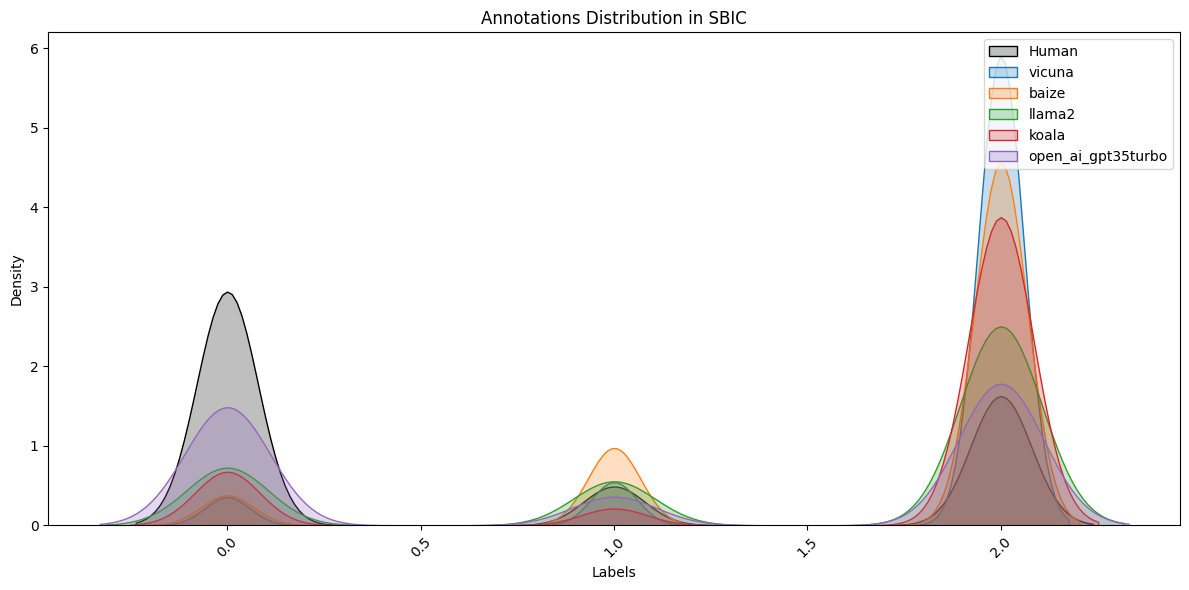

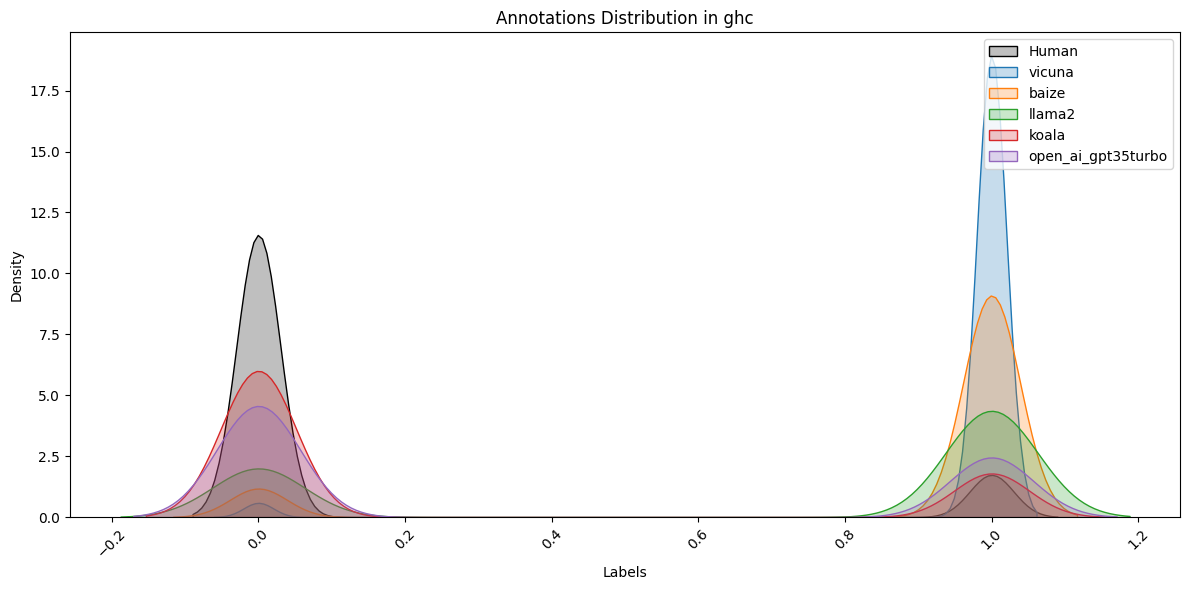

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your dataframe
# Step 1: Preprocess the Data
df = df[df['model_annots'].apply(lambda x: -1 not in x)]
df = df.explode('human_annots')
df = df.explode('model_annots')

# Step 2: Create Visualizations
for dataset in df['dataset_name'].unique():
    data_subset = df[df['dataset_name'] == dataset]

    plt.figure(figsize=(12, 6))

    # Human Annotations Plot
    sns.kdeplot(data=data_subset, x='human_annots', color='black', label='Human', fill=True)

    # Model Annotations Plot for each model
    for model in data_subset['model_name'].unique():
        model_subset = data_subset[data_subset['model_name'] == model]
        sns.kdeplot(data=model_subset, x='model_annots', label=model, fill=True)

    plt.title(f'Annotations Distribution in {dataset}')
    plt.xlabel('Labels')
    plt.ylabel('Density')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    #plt.show()
    #plt.savefig(f'plots/annotation_comparisonkde_{dataset}.png')

    # Close the figure to free up memory
    plt.close(fig)



In [ ]:
df = result_df

In [ ]:
import pandas as pd
from scipy.stats import wasserstein_distance

# Assuming df is your dataframe
# Step 1: Preprocess the Data
df = df[df['model_annots'].apply(lambda x: -1 not in x)]
df = df.explode('human_annots')
df = df.explode('model_annots')

# Converting annotations to numeric types for distance calculation
df['human_annots'] = pd.to_numeric(df['human_annots'], errors='coerce')
df['model_annots'] = pd.to_numeric(df['model_annots'], errors='coerce')

# Step 2: Calculate Wasserstein Distances
results = []

for dataset in df['dataset_name'].unique():
    for model in df['model_name'].unique():
        human_data = df[(df['dataset_name'] == dataset)]['human_annots'].dropna()
        model_data = df[(df['dataset_name'] == dataset) & (df['model_name'] == model)]['model_annots'].dropna()

        distance = wasserstein_distance(human_data, model_data)
        results.append({'dataset_name': dataset, 'model_name': model, 'wasserstein_distance': distance})

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df)


    dataset_name          model_name  wasserstein_distance
0   SChem5Labels              vicuna              0.211726
1   SChem5Labels               baize              0.158735
2   SChem5Labels              llama2              1.299433
3   SChem5Labels               koala              0.297623
4   SChem5Labels  open_ai_gpt35turbo              0.329184
5      Sentiment              vicuna              1.537016
6      Sentiment               baize              0.827698
7      Sentiment              llama2              0.976966
8      Sentiment               koala              0.773009
9      Sentiment  open_ai_gpt35turbo              0.192262
10          SBIC              vicuna              1.076384
11          SBIC               baize              0.967850
12          SBIC              llama2              0.730401
13          SBIC               koala              0.933025
14          SBIC  open_ai_gpt35turbo              0.341745
15           ghc              vicuna              0.8397

In [ ]:
#results_df.to_csv("wasserstein_distance_intramodel.csv", index = False, header = True)

In [ ]:
%cd /content/gdrive/MyDrive/subteam-tasks labels and human responses/results/plots_phase1

/content/gdrive/MyDrive/subteam-tasks labels and human responses/results/plots_phase1


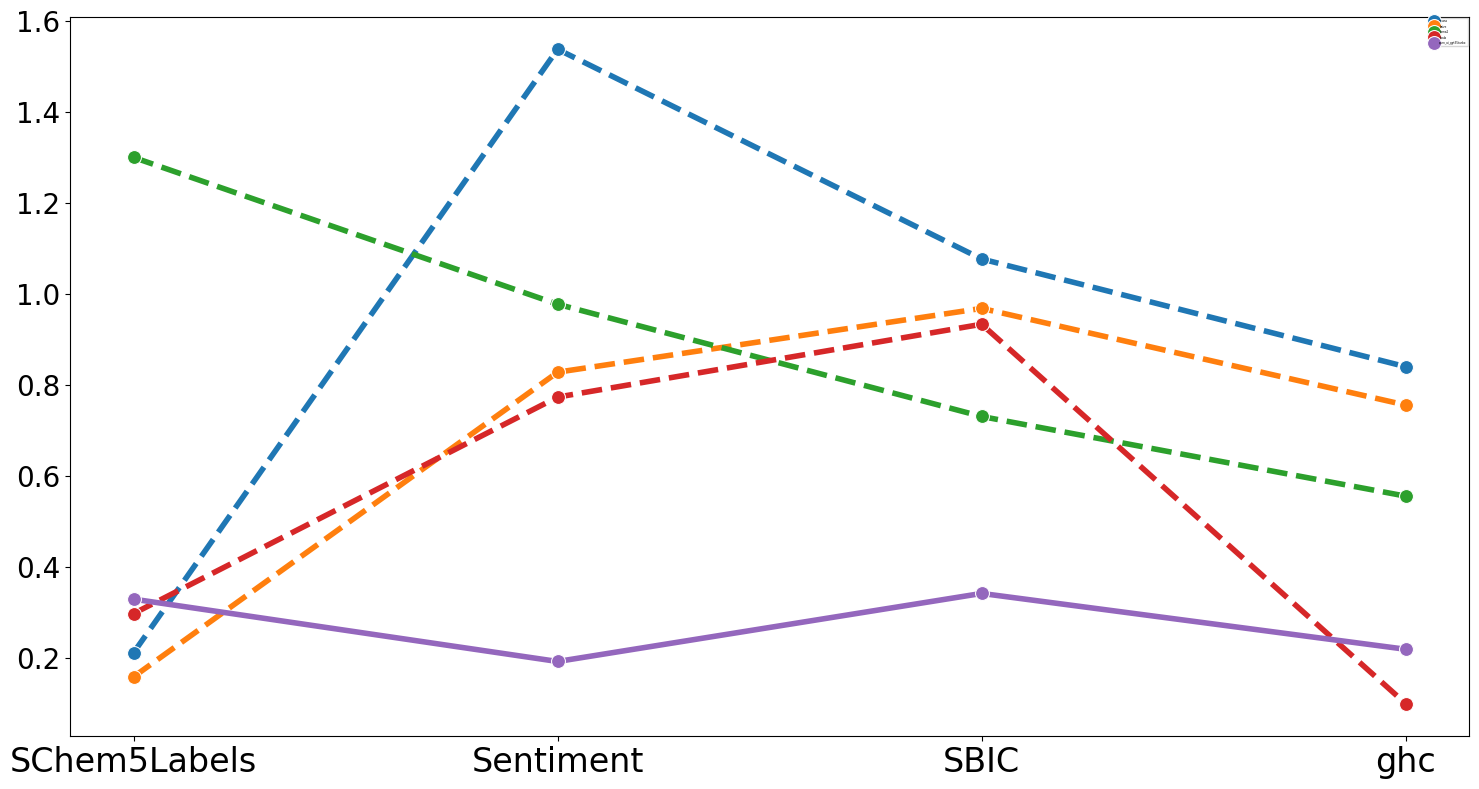

In [ ]:
# Sorting datasets for consistent ordering
results_df['dataset_name'] = pd.Categorical(results_df['dataset_name'],
                                            categories=results_df['dataset_name'].unique(),
                                            ordered=True)

plt.figure(figsize=(15, 8))

# Define unique model names
model_names = results_df['model_name'].unique()

# Loop through each model and plot the line
for model_name in model_names:
    # Subset the DataFrame
    subset = results_df[results_df['model_name'] == model_name]

    # Check if current model is 'open_ai_gpt35turbo'
    if model_name == 'open_ai_gpt35turbo':
        sns.lineplot(data=subset,
                     x='dataset_name',
                     y='wasserstein_distance',
                     label=model_name,
                     linewidth=4,
                     markersize=10,
                     linestyle='-',  # Solid line for 'open_ai_gpt35turbo'
                     marker='o')
    else:
        sns.lineplot(data=subset,
                     x='dataset_name',
                     y='wasserstein_distance',
                     label=model_name,
                     linewidth=4,
                     markersize=10,
                     linestyle='--',  # Dashed line for other models
                     marker='o')

# Rotate x-axis labels and increase font size for ticks
plt.xticks(fontsize=24)
plt.yticks(fontsize=20)
# Increase font size for axes labels and title
plt.xlabel('', fontsize=22)
plt.ylabel('', fontsize=22)
#plt.title('Model Consistency Across Datasets', fontsize=18)

# Increase font size for the legend and place it outside the plot
plt.legend(fontsize=2, title_fontsize=24, loc='upper right', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("wass_trend.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
df = result_df

In [ ]:
df = df[df['model_annots'].apply(lambda x: -1 not in x)]

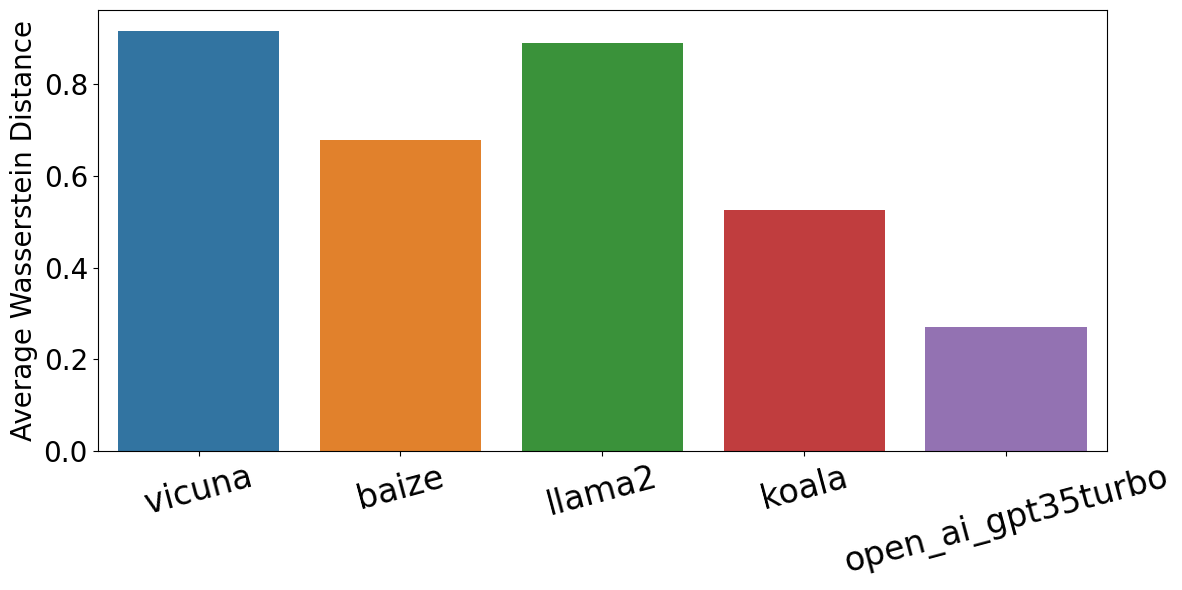

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance

# Assuming df is your dataframe
# Step 1: Preprocess the Data

df = df.explode('human_annots')
df = df.explode('model_annots')

# Step 2: Calculate Average Wasserstein Distances
results = []

for model in df['model_name'].unique():
    distances = []
    for dataset in df['dataset_name'].unique():
        human_data = df[df['dataset_name'] == dataset]['human_annots']
        model_data = df[(df['dataset_name'] == dataset) & (df['model_name'] == model)]['model_annots']

        distance = wasserstein_distance(human_data, model_data)
        distances.append(distance)

    avg_distance = sum(distances) / len(distances)
    results.append({'model_name': model, 'average_wasserstein_distance': avg_distance})

results_df = pd.DataFrame(results)

# Step 3: Visualize the Average Wasserstein Distances
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='model_name', y='average_wasserstein_distance')

plt.xticks(fontsize=24)
plt.yticks(fontsize=20)
# Increase font size for axes labels and title
plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)

#plt.xlabel('Model Name')
plt.ylabel('Average Wasserstein Distance')
#plt.title('Average Wasserstein Distance of Models Across All Datasets')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("avg_wass_distance.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()
